This is an improved kernel on [previous one](https://www.kaggle.com/cullensun/deep-learning-model-for-horse-racing). In previous kernel, I tried to predict on every single horse run. However, I found it makes more sense to predict winner horse for every race because winning is **relative** to other horses performance. 

## Import packages
Here, we import common packages for deep learning. 
- pandas: for data reading and preprocessing
- tensorflow: for neural network construction 
- sklearn.preprocessing: for data encoding
- sklearn.model_selection: it has convenient method for training/test data spliting 
- matplotlib.pyplot: to plot performance of the training process.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt

## Prepare races data from races.csv
Only select several columns that make sense for this kernel. Then, use different encoders for different types of attribute.

In [2]:
races_df = pd.read_csv(r"races.csv", delimiter=",", header=0, index_col='race_id')
races_df = races_df[['venue', 'config', 'surface', 'distance', 'going', 'race_class']]

# check to see if we have NaN, then drop NaN
print(races_df[races_df.isnull().any(axis=1)])
races_df = races_df.dropna()

Empty DataFrame
Columns: [venue, config, surface, distance, going, race_class]
Index: []


In [3]:
# encode ordinal columns: config, going, 
config_encoder = preprocessing.OrdinalEncoder()
races_df['config'] = config_encoder.fit_transform(races_df['config'].values.reshape(-1, 1))
going_encoder = preprocessing.OrdinalEncoder()
races_df['going'] = going_encoder.fit_transform(races_df['going'].values.reshape(-1, 1))

# encode nominal column: venue
venue_encoder = preprocessing.LabelEncoder()
races_df['venue'] = venue_encoder.fit_transform(races_df['venue'])

print(races_df.dtypes)
print(races_df.shape)
print(races_df.head())

venue           int64
config        float64
surface         int64
distance        int64
going         float64
race_class      int64
dtype: object
(6349, 6)
         venue  config  surface  distance  going  race_class
race_id                                                     
0            1     0.0        0      1400    2.0           5
1            1     0.0        0      1200    2.0           5
2            1     0.0        0      1400    2.0           4
3            1     0.0        0      1200    2.0           1
4            1     0.0        0      1600    2.0           4


## Prepare races data from runs.csv
Similar to races data, only select columns that are relevant to the model. 

### Data cleaning
- two rows that includes NaN, so just drop them.
- strange data for 'draw', e.g. 15. As we only deal with standard 14 horses racing, so let's drop it.

### Encoding 
Then, use label encoders for 'horse_country' and 'horse_type'.

In [5]:
runs_df = pd.read_csv(r"runs.csv", delimiter=",", header=0)
runs_df = runs_df[['race_id', 'draw', 
                   'horse_age', 'horse_country', 'horse_type', 'horse_rating', 'declared_weight', 'actual_weight', 'win_odds', 
                   'result']] 

# check to see if we have NaN, then drop NaN
print(runs_df[runs_df.isnull().any(axis=1)])
runs_df = runs_df.dropna()

# not sure why, but we got some strange draw in the dataset. Maximum shall be 14
strange_draw_index = runs_df[runs_df['draw'] > 14].index
# delete these row indexes from dataFrame
runs_df = runs_df.drop(strange_draw_index)

# encode nominal columns: horse_country, horse_type
horse_country_encoder = preprocessing.LabelEncoder()
runs_df['horse_country'] = horse_country_encoder.fit_transform(runs_df['horse_country'])
horse_type_encoder = preprocessing.LabelEncoder()
runs_df['horse_type'] = horse_type_encoder.fit_transform(runs_df['horse_type'])

print(runs_df.dtypes)
print(runs_df.shape)
print(runs_df.head())

     race_id  draw  horse_age horse_country horse_type  horse_rating  \
182       13    12          3           NaN        NaN            60   
846       69     1          3           NaN        NaN            60   

     declared_weight  actual_weight  win_odds  result  
182           1107.0            120      28.0       5  
846           1105.0            119      14.0      11  
race_id              int64
draw                 int64
horse_age            int64
horse_country        int64
horse_type           int64
horse_rating         int64
declared_weight    float64
actual_weight        int64
win_odds           float64
result               int64
dtype: object
(79444, 10)
   race_id  draw  horse_age  horse_country  horse_type  horse_rating  \
0        0     7          3              1           3            60   
1        0    12          3             11           3            60   
2        0     8          3             11           3            60   
3        0    13          3    

## Further preprocessing for runs data
We are targeting to put all the 14 horses' features into the one input, but it expands into multiple rows now. Luckily, pandas has a nice method called `pivot`. `pivot` aggregates horses data from multiple rows, which belongs to a single race, into one row. 

After `pivot`, some races may not have 14 horses, so let's fill NaN with 0.

In [6]:
def group_horse_and_result(element):
    if element[0] == 'result':
        return 100 + element[1] # to make sure results are put near the end
    else:
        return element[1]   

runs_df = runs_df.pivot(index='race_id', columns='draw', values=runs_df.columns[2:])
rearranged_columns = sorted(list(runs_df.columns.values), key=group_horse_and_result)
runs_df = runs_df[rearranged_columns]
print(runs_df.head())

# quite some NaNs appreared in the dataframe, reason is some races didnt have full 14 horses participating
# fill with 0
runs_df = runs_df.fillna(0)

        horse_age horse_country horse_type horse_rating declared_weight  \
draw           1             1          1            1               1    
race_id                                                                   
0             3.0          14.0        3.0         60.0          1089.0   
1             3.0           1.0        3.0         60.0          1059.0   
2             3.0           1.0        3.0         60.0          1028.0   
3             3.0          14.0        5.0         60.0          1074.0   
4             3.0          11.0        3.0         60.0           988.0   

        actual_weight win_odds horse_age horse_country horse_type  ... result  \
draw               1        1         2             2          2   ...     5    
race_id                                                            ...          
0               120.0      5.4       3.0           1.0        3.0  ...    3.0   
1               121.0     10.0       3.0          11.0        3.0  ...    8

In [8]:
for cur in runs_df.columns:
    print(cur[0],cur[1])

horse_age 1
horse_country 1
horse_type 1
horse_rating 1
declared_weight 1
actual_weight 1
win_odds 1
horse_age 2
horse_country 2
horse_type 2
horse_rating 2
declared_weight 2
actual_weight 2
win_odds 2
horse_age 3
horse_country 3
horse_type 3
horse_rating 3
declared_weight 3
actual_weight 3
win_odds 3
horse_age 4
horse_country 4
horse_type 4
horse_rating 4
declared_weight 4
actual_weight 4
win_odds 4
horse_age 5
horse_country 5
horse_type 5
horse_rating 5
declared_weight 5
actual_weight 5
win_odds 5
horse_age 6
horse_country 6
horse_type 6
horse_rating 6
declared_weight 6
actual_weight 6
win_odds 6
horse_age 7
horse_country 7
horse_type 7
horse_rating 7
declared_weight 7
actual_weight 7
win_odds 7
horse_age 8
horse_country 8
horse_type 8
horse_rating 8
declared_weight 8
actual_weight 8
win_odds 8
horse_age 9
horse_country 9
horse_type 9
horse_rating 9
declared_weight 9
actual_weight 9
win_odds 9
horse_age 10
horse_country 10
horse_type 10
horse_rating 10
declared_weight 10
actual_weigh

## Prepare training/test data 
Here, we combine races data and runs data by `join` two data frames above. 

### Standardization
If you look at the data closely, if will find that features are not in the same scale, e.g. weight can go to 1000+. Standardize the data for to make training easier. 

### Select right columns for X, y
- Select all the data except last 28 columns, because last 28 columns is about 'result' and 'won'
- Select last 14 columns for y_won. Each row shall have one '1.0' and rest are 0. 
- Select second last 14 columns for y_top3. It used to the the column 'result', e.g. 1~14, which is horses' final positions when the race finishes. Apply a function to convert it to 1.0 if the horse is in top 3, else 0. 

### Split data into train/test sets

sklearn comes with such a handy method `train_test_split`. We split the data as following:
- 80% for training
- 20% for testing(validation)


In [9]:
data = races_df.join(runs_df, on='race_id', how='right')
X = data[data.columns[:-14]] 
ss = preprocessing.StandardScaler()
X = pd.DataFrame(ss.fit_transform(X),columns = X.columns)

y_won = data[data.columns[-14:]].applymap(lambda x: 1.0 if 0.5 < x < 1.5 else 0.0) 

print(X.shape)
print(y_won.shape)

# split data into train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_won, train_size=0.8, test_size=0.2, random_state=1)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

/home/winnie/developer/conda_env/ml-toolbox/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


(6348, 104)
(6348, 14)
X_train (5078, 104)
y_train (5078, 14)
X_test (1270, 104)
y_test (1270, 14)


In [14]:
X.columns

Index([                'venue',                'config',
                     'surface',              'distance',
                       'going',            'race_class',
              ('horse_age', 1),    ('horse_country', 1),
             ('horse_type', 1),     ('horse_rating', 1),
       ...
       ('declared_weight', 13),   ('actual_weight', 13),
              ('win_odds', 13),       ('horse_age', 14),
         ('horse_country', 14),      ('horse_type', 14),
          ('horse_rating', 14), ('declared_weight', 14),
         ('actual_weight', 14),        ('win_odds', 14)],
      dtype='object', length=104)

In [13]:
data.iloc[:,-14:].head()

,"(result, 1)","(result, 2)","(result, 3)","(result, 4)","(result, 5)","(result, 6)","(result, 7)","(result, 8)","(result, 9)","(result, 10)","(result, 11)","(result, 12)","(result, 13)","(result, 14)"
race_id,,,,,,,,,,,,,,
0,11.0,1.0,2.0,5.0,3.0,13.0,10.0,7.0,14.0,4.0,12.0,8.0,9.0,6.0
1,4.0,11.0,7.0,6.0,8.0,2.0,5.0,10.0,12.0,1.0,3.0,9.0,14.0,13.0
2,13.0,2.0,8.0,1.0,14.0,6.0,4.0,7.0,9.0,10.0,5.0,11.0,3.0,12.0
3,7.0,4.0,5.0,1.0,3.0,11.0,8.0,9.0,6.0,12.0,2.0,10.0,0.0,0.0
4,9.0,5.0,1.0,3.0,14.0,6.0,2.0,8.0,10.0,13.0,7.0,4.0,11.0,12.0


## Build the model

Use keras to build the model with easy-to-use api `Sequential`. 

Have to mention that input layer has 104 inputs. The calculation is following:
- 6 features from races dataframe: 'venue', 'config', 'surface', 'distance', 'going', 'race_class'
- 14 horses per races, and each horse has 7 features; 'horse_age', 'horse_country', 'horse_type', 'horse_rating', 'declared_weight', 'actual_weight', 'win_odds'
- so total 104 features = 6 + 14 x 7


Output layer has 14 nodes, as each node stands for each horse's result.

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(96, activation='relu', input_shape=(104,)),
    tf.keras.layers.Dense(14, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(5e-04),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Precision(name='precision')])

## Train the model

In [51]:
dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
train_dataset = dataset.shuffle(len(X_train)).batch(500)
dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
validation_dataset = dataset.shuffle(len(X_test)).batch(500)

print("Start training..\n")
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset)
print("Done.")

Start training..

Train for 11 steps, validate for 3 steps
Epoch 1/200
11/11 [==============================] - 1s 56ms/step - loss: 2.9226 - precision: 0.0709 - val_loss: 2.8180 - val_precision: 0.0000e+00
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 2.7859 - precision: 0.0690 - val_loss: 2.7430 - val_precision: 0.0714
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 2.7040 - precision: 0.0833 - val_loss: 2.6858 - val_precision: 0.1667
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 2.6472 - precision: 0.1111 - val_loss: 2.6486 - val_precision: 0.2000
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 2.6007 - precision: 0.0909 - val_loss: 2.6248 - val_precision: 0.3333
Epoch 6/200
11/11 [==============================] - 0s 6ms/step - loss: 2.5633 - precision: 0.2000 - val_loss: 2.6067 - val_precision: 0.5000
Epoch 7/200
11/11 [==============================] - 0s 6ms/step - loss: 2.527

Epoch 57/200
11/11 [==============================] - 0s 6ms/step - loss: 1.9518 - precision: 0.9126 - val_loss: 2.4193 - val_precision: 0.2778
Epoch 58/200
11/11 [==============================] - 0s 6ms/step - loss: 1.9498 - precision: 0.9175 - val_loss: 2.4240 - val_precision: 0.2500
Epoch 59/200
11/11 [==============================] - 0s 6ms/step - loss: 1.9435 - precision: 0.9082 - val_loss: 2.4255 - val_precision: 0.2727
Epoch 60/200
11/11 [==============================] - 0s 6ms/step - loss: 1.9255 - precision: 0.9118 - val_loss: 2.4212 - val_precision: 0.1905
Epoch 61/200
11/11 [==============================] - 0s 6ms/step - loss: 1.9256 - precision: 0.9123 - val_loss: 2.4178 - val_precision: 0.2222
Epoch 62/200
11/11 [==============================] - 0s 6ms/step - loss: 1.9190 - precision: 0.8992 - val_loss: 2.4150 - val_precision: 0.2727
Epoch 63/200
11/11 [==============================] - 0s 6ms/step - loss: 1.9098 - precision: 0.9055 - val_loss: 2.4261 - val_precision:

11/11 [==============================] - 0s 6ms/step - loss: 1.4799 - precision: 0.9051 - val_loss: 2.6419 - val_precision: 0.2083
Epoch 170/200
11/11 [==============================] - 0s 6ms/step - loss: 1.4746 - precision: 0.9048 - val_loss: 2.6430 - val_precision: 0.2124
Epoch 171/200
11/11 [==============================] - 0s 6ms/step - loss: 1.4883 - precision: 0.9025 - val_loss: 2.6458 - val_precision: 0.2124
Epoch 172/200
11/11 [==============================] - 0s 6ms/step - loss: 1.4695 - precision: 0.9005 - val_loss: 2.6493 - val_precision: 0.1818
Epoch 173/200
11/11 [==============================] - 0s 6ms/step - loss: 1.4535 - precision: 0.8994 - val_loss: 2.6644 - val_precision: 0.1990
Epoch 174/200
11/11 [==============================] - 0s 6ms/step - loss: 1.4657 - precision: 0.9025 - val_loss: 2.6689 - val_precision: 0.1980
Epoch 175/200
11/11 [==============================] - 0s 6ms/step - loss: 1.4690 - precision: 0.9094 - val_loss: 2.6620 - val_precision: 0.2010

## Plot the result


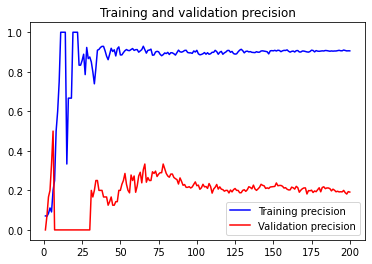

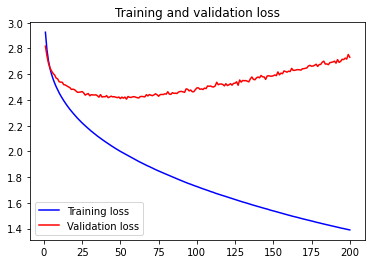

In [52]:
precision = history.history['precision']
val_precision = history.history['val_precision']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(precision) + 1)

plt.plot(epochs, precision, 'b', label='Training precision')
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'val_precision' is not defined

## Conclusion

With the 2 layer nerual network, we reached 0.92 precision on the the training dataset. However, best precision on the testing dataset was about 0.3, which happened around epoch 70~80. Then overfitting happened. 

precision = 0.3, means If we bet 'Win' 10 times based on the model's prediction, only 3 times is correct.  